In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

**Model Comparison** \
The cell below uses the identified stock or index and compares the r2 results of three models, given different features combinations.\
The three models are Linear Regression, Support Vector Regression, and Decision Tree Regression.

In [2]:
from daily_stock_price import get_stock_prices
from supervised_data_prep import pre_process_data, feature_selection
from supervised_modeling import model_comparison

# identify the ticker for the selected stock / index
TICKER = 'GME'               

# retrive training and test reddit data for model comparison and scoring (note: validation set is not included in data below, data > Sept30th)
df_communites = pd.read_csv('../koigawa_milestone_II/community_output_gme_train.csv')
df_topics = pd.read_csv('../smoilanen_milestone_II/df_train.csv')

# retrive stock prices for the same time period as above
MIN_DATE = df_communites['date'].min()[:10]
MAX_DATE = df_communites['date'].max()[:10]
df_prices = get_stock_prices(TICKER, start=MIN_DATE, end=MAX_DATE)

# data from market and reddit is combined, cleaned
# selections for feature shifting, rolling average, or stock price edits can be made here
df_pre_processed = pre_process_data(df_prices, df_communites, df_topics, MIN_DATE, MAX_DATE, TICKER, shift=1, rolling_avg=0, stock_price='log')

# select the top 10 features based on their correlation with the target variable
FEATURES = feature_selection(df_pre_processed, TICKER)[:10]

# compare three models using different feature selections
results = model_comparison(df_pre_processed, TICKER, features=FEATURES)
results

,model,features,best_params,best_mse
0,Linear,Scriptophobic community talking about Meme & P...,{'Linear__fit_intercept': True},12.769399
1,Support Vector (SVR),Scriptophobic community talking about Meme & P...,"{'Support Vector (SVR)__C': 0.1, 'Support Vect...",0.015988
2,Decision Tree,Scriptophobic community talking about Meme & P...,"{'Decision Tree__criterion': 'squared_error', ...",0.162863


**Original exploratory analysis requires updating given significant structural changes in code**\
|\
|\
v

**Reddit Posts** 
- Reddit data will be provided by the topic and clustering data.\
- It will be in the same format, but include a community and topic label for each row. \
- For now, we will just view the data. 

In [2]:
# retrieve reddit data
df = pd.read_csv('../koigawa_milestone_II/community_output_gme_train.csv')
df['date'] = df['date'].astype('datetime64[ns]')

#capture timeframe of reddit data
MIN_DATE = df['date'].min()
MAX_DATE = '2021-09-30' #df['date'].max()

df.head()

,Unnamed: 0,id,author,date,selftext,community_label
0,0,kqfajb,TitsDownOnly,2021-01-04 19:02:26,After watching this I took a position RIGHT AW...,0.0
1,1,kqvp7l,TitsDownOnly,2021-01-05 10:19:59,This guy explained exactly how to take a posit...,0.0
2,2,kuo3w1,TitsDownOnly,2021-01-10 21:59:17,"After some downwards movement, I think everyb...",0.0
3,5,kyodi5,TitsDownOnly,2021-01-16 18:31:13,The enormous moves that are right now expected...,0.0
4,6,l09lgy,TitsDownOnly,2021-01-19 02:03:35,By looking at what happened in 2008 with the i...,0.0


**Stock Price History (daily_stock_price.py)**\
Retrives the stock prices for the ticker and timeline provided.
- The best index/stock determined through manual inspection
- Alternative, try and extract reference stock / indicies

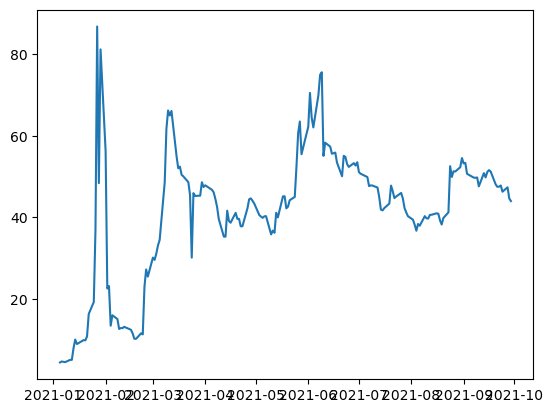

In [3]:
# index / stock options 
    # VOO: S&P 500 index
    # FSMDX: Mid cap index fund
    # SFSNX: Mid cap index fund 
    # XLK: Technology sector stock index 
    # MEME: Meme stock index 
    # GME: Gamestop stock

# retrive stock price data, saves csv and chart png
from daily_stock_price import get_stock_prices
TICKER = 'GME'
get_stock_prices(ticker = TICKER, start = MIN_DATE, end = MAX_DATE)

**Pre-Processing Market and Reddit Data (supervised_data_prep.py)**
- Stock price data will fill missing dates with previous dates stock price (ffill over days when market is closed). 
- Reddit data will be joined to stock price data.
- Missing reddit dates are added as zeros.  
- Dummy cluster and topic labels are added to reddit data temporarily.
- Reddit data is grouped by date and community / topic, values are counted.

In [4]:
# submissions_reddit file will be provided with community and topic labels
from supervised_data_prep import process_financial_data, process_reddit_data, combine_data

# will process stock data and save a csv 'stock_prices_clean.csv
process_financial_data('stock_prices.csv', MIN_DATE, MAX_DATE)

# will process reddit data (including dummy topics / clusters) and save as csv 'community_discussion_counts_clean.csv'
process_reddit_data('../koigawa_milestone_II/community_output_gme_train.csv', '../smoilanen_milestone_II/df_test_train_split.csv')

# combine market and reddit data
combine_data('community_discussion_counts_clean.csv', 'stock_prices_clean.csv')

**Visualize Community / Topic Activity**
- Viewing the comunity group & topic activity and changes in the stock price.

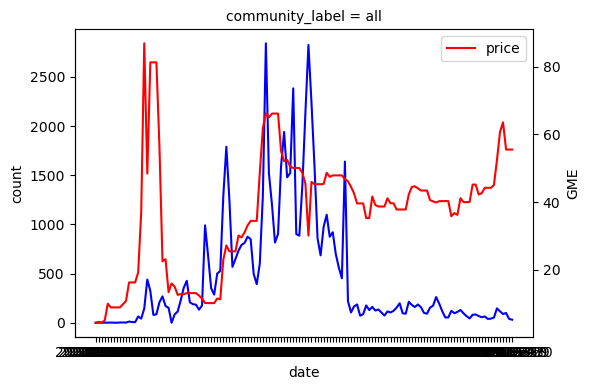

In [5]:
df = pd.read_csv('combined_data.csv')
feature_cols = df.columns[-1:]
df = pd.melt(df, id_vars=['date', TICKER], value_vars=feature_cols, value_name='count', var_name='community_label')

g = sns.FacetGrid(data=df, row="community_label", height=4, aspect=1.5)

# plotting function
def plot_dual_axis(data, **kwargs):
    ax = plt.gca()
    sns.lineplot(data=data, x='date', y='count', ax=ax, color='b', label='count')
    ax2 = ax.twinx()
    sns.lineplot(data=data, x='date', y=TICKER, ax=ax2, color='r', label='price')

# create grid for each community and topic label
g.map_dataframe(plot_dual_axis)
plt.show()

**Model Evaluation (supervised_modeling.py)**\
- Community/topic activity is compared with market data.\
- This is also explored within three different supervised learning models.\
- Output is the r2 value for each model and community/topic.\
- Hyperparameter tuning embedded in modelling will occur after preferred model is selected. 

In [6]:
from supervised_modeling import model_comparison

# returns r2 values for each model / community&topic combination when compared 
# against the selected market data
results = model_comparison(pd.read_csv('combined_data.csv'), TICKER, features=['all'])

**Visualize Model Results**\
- Using R2 to examine the extent to which the variance in stock / index price is explained by the variance in community activity. 

Text(0.5, 1.0, 'R2 Results of Community Activity Using Different Regression Models')

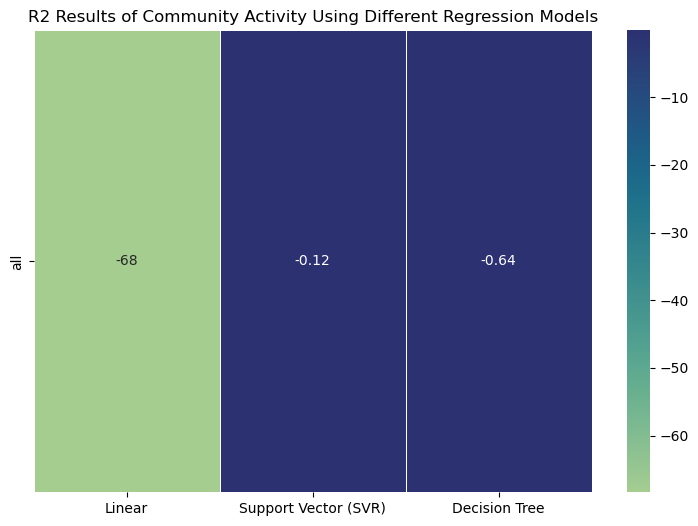

In [7]:
# heatmap of the results 
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(results, annot=True, linewidths=.5, ax=ax, cmap='crest')
plt.title('R2 Results of Community Activity Using Different Regression Models')